**Donors Choose**

Goal-Predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school

In [165]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## Importing the data

In [166]:
data=pd.read_csv("train_data.csv")
resources=pd.read_csv("resources.csv")

In [167]:
data.shape

(109248, 17)

In [168]:
data=data.dropna(subset=['teacher_prefix'])

In [169]:
data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0  
3                                             4                    1  
4                                             1                    1

In [170]:
resources.shape

(1541272, 4)

In [171]:
resources.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [172]:
#keeping a list of the column names and replacing "project_submitted_datetime" with just 'Date'
cols=['Date' if x=='project_submitted_datetime' else x for x in list(data.columns)]

#create a new column 'Date' by converting the 'project_submitted_datetime' to pandas date_time format
data['Date'] = pd.to_datetime(data['project_submitted_datetime'])
#dropping the 'project_submitted_datetime' column
data.drop('project_submitted_datetime', axis=1, inplace=True)
#sort as per the date
data.sort_values(by=['Date'], inplace=True)

In [173]:
data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           Mrs.   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state project_grade_category project_subject_categories  \
55660           CA          Grades PreK-2             Math & Science   
76127           UT             Grades 3-5              Special Needs   
51140           CA          Grades PreK-2        Literacy & Language   
473             GA          Grades PreK-2           Applied Learning   
41558           WA             Grades 3-5        Literacy & Language   

                 project_subject_subcategories  \
55660  Applied Sciences, Health & Life Science   
76127                            Special Needs   
51140                                 Literacy   
473                          Early Development   
41558                                 Literacy   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   
473            Flexible Seating for Flexible Learning   
41558          Going Deep: The Art of Inner Thinking!   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   
473                                               2                    1   
41558                                             2                    1   

                     Date  
55660 2016-04-27 00:27:36  
76127 2016-04-27 00:31:25  
51140 2016-04-27 00:46:53  
473   2016-04-27 00:53:00  
41558 2016-04-27 01:05:25

The newly created 'date' column has been added to the end but we want to bring it to the original position of 'project_submitted_datetime' column

In [174]:
data=data[cols]
data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1

## Pre-processing

###  project_subject_categories

In [175]:
categories=list(data['project_subject_categories'].values)

# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        j = j.replace('&','_')
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
    cat_list.append(temp.strip())
    
data['clean_categories'] = cat_list
data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in data['clean_categories'].values:
    my_counter.update(word.split())    #my_counter keeps track of the number of occurences for a particular word

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

###  project_subject_subcategories

In [176]:
sub_categories=list(data['project_subject_subcategories'].values)

sub_cat_list=[]
for i in sub_categories:
    temp=""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','')
        j = j.replace('&','_')
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
    sub_cat_list.append(temp.strip())
    
data['clean_subcategories']=sub_cat_list    
data.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [177]:
from collections import Counter
my_counter = Counter()
for word in data['clean_subcategories'].values:
    my_counter.update(word.split())    #my_counter keeps track of the number of occurences for a particular word

sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [178]:
data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           Mrs.   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   
51140           CA 2016-04-27 00:46:53          Grades PreK-2   
473             GA 2016-04-27 00:53:00          Grades PreK-2   
41558           WA 2016-04-27 01:05:25             Grades 3-5   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   
473            Flexible Seating for Flexible Learning   
41558          Going Deep: The Art of Inner Thinking!   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   
473                                               2                    1   
41558                                             2                    1   

        clean_categories                 clean_subcategories  
55660       Math_Science  AppliedSciences Health_LifeScience  
76127       SpecialNeeds                        SpecialNeeds  
51140  Literacy_Language                            Literacy  
473      AppliedLearning                    EarlyDevelopment  
41558  Literacy_Language                            Literacy

### essay

#####  Merging 'project_essay_1','project_essay_2','project_essay_3','project_essay_4' into a single column 'essay' -

In [179]:
data['essay']=data['project_essay_1'].map(str)+data['project_essay_2'].map(str)+data['project_essay_3'].map(str)+data['project_essay_4'].map(str)

In [180]:
data['essay'].values[0]

"I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, s

##### Removing characters like '\r', '\n' ,'\t' etc. and also the stopwords from each instance of essay and decontracting the short forms -

In [181]:
# https://stackoverflow.com/a/47091490/4084039
import re
#function to perform decontraction
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [182]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [183]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentence in tqdm(data['essay'].values):
    sent = decontracted(sentence)
    #remove \r \n \t from the sentence
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    #remove all characters other than alphabets and digits
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    #remove stopwords
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())


100%|██████████| 109245/109245 [00:52<00:00, 2084.49it/s]


In [184]:
preprocessed_essays[0]

'fortunate enough use fairy tale stem kits classroom well stem journals students really enjoyed would love implement lakeshore stem kits classroom next school year provide excellent engaging stem lessons students come variety backgrounds including language socioeconomic status many not lot experience science engineering kits give materials provide exciting opportunities students month try several science stem steam projects would use kits robot help guide science instruction engaging meaningful ways adapt kits current language arts pacing guide already teach material kits like tall tales paul bunyan johnny appleseed following units taught next school year implement kits magnets motion sink vs float robots often get units not know teaching right way using right materials kits give additional ideas strategies lessons prepare students science challenging develop high quality science activities kits give materials need provide students science activities go along curriculum classroom altho

In [185]:
data['essay']=preprocessed_essays

In [186]:
data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           Mrs.   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   
51140           CA 2016-04-27 00:46:53          Grades PreK-2   
473             GA 2016-04-27 00:53:00          Grades PreK-2   
41558           WA 2016-04-27 01:05:25             Grades 3-5   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   
473            Flexible Seating for Flexible Learning   
41558          Going Deep: The Art of Inner Thinking!   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   
473                                               2                    1   
41558                                             2                    1   

        clean_categories                 clean_subcategories  \
55660       Math_Science  AppliedSciences Health_LifeScience   
76127       SpecialNeeds                        SpecialNeeds   
51140  Literacy_Language                            Literacy   
473      AppliedLearning                    EarlyDevelopment   
41558  Literacy_Language                            Literacy   

                                                   essay  
55660  fortunate enough use fairy tale stem kits clas...  
76127  imagine 8 9 years old thir

### project_title

In [187]:
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(data['project_title'].values):
    #remove \r \n \t from the sentence
    sentence = sentence.replace('\\r', ' ')
    sentence = sentence.replace('\\"', ' ')
    sentence = sentence.replace('\\n', ' ')
    #remove all characters other than alphabets and digits
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    #remove stopwords
    sentence = ' '.join(e for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sentence.lower().strip())

100%|██████████| 109245/109245 [00:01<00:00, 78634.08it/s]


In [280]:
data['project_title_pro']=preprocessed_titles
data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5            mrs   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df             ms   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73            mrs   

      school_state                Date project_grade_category  \
55660           ca 2016-04-27 00:27:36          grades_prek_2   
76127           ut 2016-04-27 00:31:25             grades_3_5   
51140           ca 2016-04-27 00:46:53          grades_prek_2   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   

        clean_categories                 clean_subcategories  \
55660       Math_Science  AppliedSciences Health_LifeScience   
76127       SpecialNeeds                        SpecialNeeds   
51140  Literacy_Language                            Literacy   

                                                   essay  \
55660  fortunate enough use fairy tale stem kits clas...   
76127  imagine 8 9 years old third grade classroom se...   
51140  class 24 students comes diverse learners stude...   

                             project_title_pro  
55660      engineering steam primary classroom  
76127                      sensory tools focus  
51140  mobile learning mobile listening center

### project_grade_category

In [281]:
data['project_grade_category'].unique()

array(['grades_prek_2', 'grades_3_5', 'grades_9_12', 'grades_6_8'],
      dtype=object)

In [282]:
project_categories=list(data['project_grade_category'].values)

project_cat_list=[]
for i in project_categories:
    #replacing spaces and '-' with '_'
    i=i.replace(' ','_')
    i=i.replace('-','_')
    project_cat_list.append(i.lower())
    
data['project_grade_category']=project_cat_list    

In [ ]:
data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          grades_prek_2   
76127           UT 2016-04-27 00:31:25             grades_3_5   
51140           CA 2016-04-27 00:46:53          grades_prek_2   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   

        clean_categories                 clean_subcategories  \
55660       Math_Science  AppliedSciences Health_LifeScience   
76127       SpecialNeeds                        SpecialNeeds   
51140  Literacy_Language                            Literacy   

                                                   essay  \
55660  fortunate enough use fairy tale stem kits clas...   
76127  imagine 8 9 years old third grade classroom se...   
51140  class 24 students comes diverse learners stude...   

                             project_title_pro  
55660      engineering steam primary classroom  
76127                      sensory tools focus  
51140  mobile learning mobile listening center

### school_state

In [ ]:
states=list(data['school_state'].values)

states_list=[]
for i in states:
    states_list.append(i.lower())
    
data['school_state']=states_list 

### teacher_prefix

In [ ]:
data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [ ]:
teacher_prefix=list(data['teacher_prefix'].values)
required_prefix=['Mrs.', 'Ms.', 'Mr.', 'Teacher','Dr.']     
prefix_list=[]
for i in teacher_prefix:
    i=i.replace('.','')
    prefix_list.append(i.lower())
data['teacher_prefix']=prefix_list

### Merging the 'price' column from 'resources' dataframe

In [ ]:
#https://stackoverflow.com/a/42765878
merged=pd.merge(data,resources[['id','price']],on='id', how='left')

In [ ]:
merged.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5            mrs   
1        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5            mrs   

  school_state                Date project_grade_category  \
0           ca 2016-04-27 00:27:36          grades_prek_2   
1           ca 2016-04-27 00:27:36          grades_prek_2   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1  Engineering STEAM into the Primary Classroom   

                                     project_essay_1  \
0  I have been fortunate enough to use the Fairy ...   
1  I have been fortunate enough to use the Fairy ...   

                                     project_essay_2  \
0  My students come from a variety of backgrounds...   
1  My students come from a variety of backgrounds...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  Each month I try to do several science or STEM...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  It is challenging to develop high quality scie...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need STEM kits to learn critical s...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                            53                    1   

  clean_categories                 clean_subcategories  \
0     Math_Science  AppliedSciences Health_LifeScience   
1     Math_Science  AppliedSciences Health_LifeScience   

                                               essay  \
0  fortunate enough use fairy tale stem kits clas...   
1  fortunate enough use fairy tale stem kits clas...   

                     project_title_pro   price  
0  engineering steam primary classroom   59.99  
1  engineering steam primary classroom  377.06

In [ ]:
preprocessed_data=merged[['school_state','teacher_prefix','teacher_number_of_previously_posted_projects','project_grade_category','project_title_pro','clean_categories','clean_subcategories','essay','price','project_is_approved']]

In [ ]:
preprocessed_data.head(5)

school_state teacher_prefix  teacher_number_of_previously_posted_projects  \
0           ca            mrs                                            53   
1           ca            mrs                                            53   
2           ca            mrs                                            53   
3           ca            mrs                                            53   
4           ut             ms                                             4   

  project_grade_category                    project_title_pro  \
0          grades_prek_2  engineering steam primary classroom   
1          grades_prek_2  engineering steam primary classroom   
2          grades_prek_2  engineering steam primary classroom   
3          grades_prek_2  engineering steam primary classroom   
4             grades_3_5                  sensory tools focus   

  clean_categories                 clean_subcategories  \
0     Math_Science  AppliedSciences Health_LifeScience   
1     Math_Science  AppliedSciences Health_LifeScience   
2     Math_Science  AppliedSciences Health_LifeScience   
3     Math_Science  AppliedSciences Health_LifeScience   
4     SpecialNeeds                        SpecialNeeds   

                                               essay   price  \
0  fortunate enough use fairy tale stem kits clas...   59.99   
1  fortunate enough use fairy tale stem kits clas...  377.06   
2  fortunate enough use fairy tale stem kits clas...  149.00   
3  fortunate enough use fairy tale stem kits clas...  139.00   
4  imagine 8 9 years old third grade classroom se...   27.00   

   project_is_approved  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1

In [ ]:
preprocessed_data_sample=preprocessed_data.sample(n=50000)
preprocessed_data_sample.shape

(50000, 10)

In [ ]:
y=preprocessed_data_sample['project_is_approved'].values
X=preprocessed_data_sample.drop(['project_is_approved'],axis=1)

## Splitting data into Train and cross validation(or test): Stratified Sampling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

## Making data model ready

### Encoding categorical feature: *school_state*

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

In [ ]:
print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### Encoding categorical features: *teacher_prefix*

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### Encoding categorical features: *project_grade_category*

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### Encoding numerical features: *Price*

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

### Encoding numerical features: *teacher_number_of_previously_posted_projects*

In [ ]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_project_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_project_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_project_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

### Encoding  text features *essay* and *project_title* - BOW(Set1)

**essay**

In [ ]:
print("Before Vectorization")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)  #min_df=10 means minimum document frequency of a word should be 10
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorization")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

Before Vectorization
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
After vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


**project_title**

In [ ]:
print("Before Vectorization")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)  #min_df=10 means minimum document frequency of a word should be 10
vectorizer.fit(X_train['project_title_pro'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_bow = vectorizer.transform(X_train['project_title_pro'].values)
X_cv_project_title_bow = vectorizer.transform(X_cv['project_title_pro'].values)
X_test_project_title_bow = vectorizer.transform(X_test['project_title_pro'].values)

print("After vectorization")
print(X_train_project_title_bow.shape, y_train.shape)
print(X_cv_project_title_bow.shape, y_cv.shape)
print(X_test_project_title_bow.shape, y_test.shape)
print("="*100)

Before Vectorization
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
After vectorization
(22445, 1815) (22445,)
(11055, 1815) (11055,)
(16500, 1815) (16500,)


### Encoding text features essay and project_title - TFIDF(Set2)

**essay**

In [ ]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)  #min_df=10 means minimum document frequency of a word should be 10
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

**project_title**

In [ ]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)  #min_df=10 means minimum document frequency of a word should be 10
vectorizer.fit(X_train['project_title_pro'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_tfidf = vectorizer.transform(X_train['project_title_pro'].values)
X_cv_project_title_tfidf = vectorizer.transform(X_cv['project_title_pro'].values)
X_test_project_title_tfidf = vectorizer.transform(X_test['project_title_pro'].values)

### Encoding text features essay and project_title - AvgW2V(Set3)

**essay**

In [ ]:
# storing variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# average Word2Vec
# compute average word2vec for each sentence.
avg_w2v_essay_train = []; # the avg-w2v for each sentence in training set is stored in this list
for sentence in X_train['essay'].values: # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_train.append(vector)
    
avg_w2v_essay_cv = []; # the avg-w2v for each sentence in cross-validation set is stored in this list
for sentence in X_cv['essay'].values: # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_cv.append(vector)   
    
avg_w2v_essay_test = []; # the avg-w2v for each sentence in test set is stored in this list
for sentence in X_test['essay'].values: # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_test.append(vector)    

**project_tile**

In [ ]:
avg_w2v_title_train = []; # the avg-w2v for each sentence in training set is stored in this list
for sentence in X_train['project_title_pro'].values: # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_train.append(vector)
    
avg_w2v_title_cv = []; # the avg-w2v for each sentence in cross-validation set is stored in this list
for sentence in X_cv['project_title_pro'].values: # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_cv.append(vector)   
    
avg_w2v_title_test = []; # the avg-w2v for each sentence in test set is stored in this list
for sentence in X_test['project_title_pro'].values: # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_test.append(vector)    

### Encoding text features essay and project_title - TfIdf Weighted W2V(Set4)

**essay**

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())

In [ ]:
tfidf_w2v_essay_train = []; 
for sentence in (X_train['essay'].values): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_train.append(vector)

tfidf_w2v_essay_cv = []; 
for sentence in (X_cv['essay'].values): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_cv.append(vector)
    
tfidf_w2v_essay_test = []; 
for sentence in (X_test['essay'].values): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_test.append(vector)    

**project_title**

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['project_title_pro'].values) # fit has to happen only on train data
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())

In [ ]:
tfidf_w2v_title_train = []; 
for sentence in (X_train['project_title_pro'].values): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

tfidf_w2v_title_cv = []; 
for sentence in (X_cv['project_title_pro'].values): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)
    
tfidf_w2v_title_test = []; 
for sentence in (X_test['project_title_pro'].values): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split(): 
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)    

## Modelling: Applying KNN on Set1

### Concatenating all the features

In [294]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_project_title_bow,X_train_project_norm.reshape(-1,1),X_train_price_norm.reshape(-1,1),X_train_grade_ohe,X_train_teacher_ohe,X_train_state_ohe)).tocsr()
X_cr = hstack((X_cv_essay_bow,X_cv_project_title_bow,X_cv_project_norm.reshape(-1,1),X_cv_price_norm.reshape(-1,1),X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_state_ohe)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_project_title_bow,X_test_project_norm.reshape(-1,1),X_test_price_norm.reshape(-1,1),X_test_grade_ohe,X_test_teacher_ohe,X_test_state_ohe)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(22445, 6808) (22445,)
(11055, 6808) (11055,)
(16500, 6808) (16500,)


### Hyperparameter tuning

In [ ]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████| 5/5 [05:45<00:00, 69.00s/it]


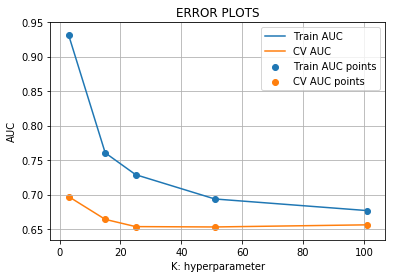

In [295]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

From the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less.

So,from the graph the best k is found out to be **101** and now using this k we will rebuild our model and plot the roc curve to evaluate the performance on test set.

In [284]:
best_k=101

### Evaluation

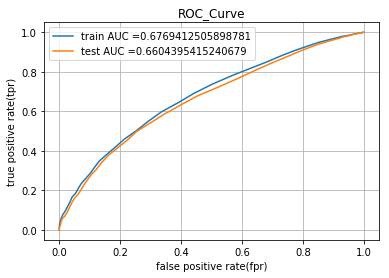

In [296]:
from sklearn.metrics import auc,roc_curve

classifier=KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
classifier.fit(X_tr,y_train)

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate(fpr)")
plt.ylabel("true positive rate(tpr)")
plt.title("ROC_Curve")
plt.grid()
plt.show()

In [286]:
#function to find the best threshold which gives the least fpr and maximum tpr
def find_best_threshold(threshold, fpr, tpr):
    best_t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr) is ", max(tpr*(1-fpr)), "for threshold of ", np.round(best_t,3))
    print('\n')
    return best_t
#function to predict the class labels based on a given threshold
def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        #if the probability is greater than or equal to threshold then classify as 1 else 0
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Finding the best threshold and displaying the Confusion Matrix of train and test set for predictions using this threshold

In [297]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("\nTest confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) is  0.3968703762074356 for threshold of  0.743


Train confusion matrix
[[ 3062  1550]
 [ 7173 10660]]

Test confusion matrix
[[2217 1173]
 [5421 7689]]


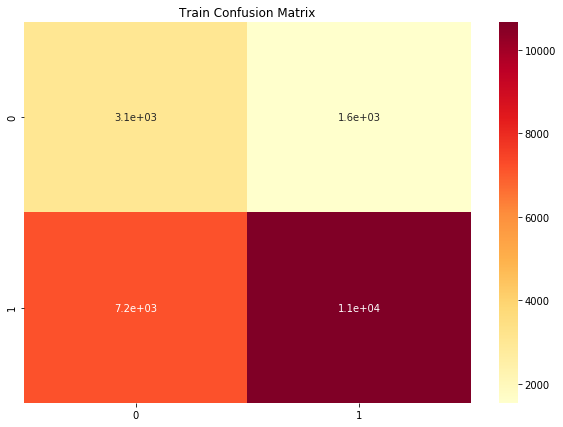

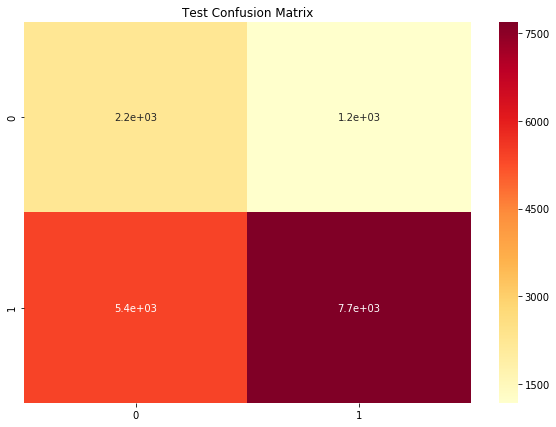

In [298]:
matrix_df = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Train Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')
matrix_df = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Test Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')

## Modelling: Applying KNN on Set2

### Concatenating all the features

In [289]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,X_train_project_title_tfidf,X_train_project_norm.reshape(-1,1),X_train_price_norm.reshape(-1,1),X_train_grade_ohe,X_train_teacher_ohe,X_train_state_ohe)).tocsr()
X_cr = hstack((X_cv_essay_tfidf,X_cv_project_title_tfidf,X_cv_project_norm.reshape(-1,1),X_cv_price_norm.reshape(-1,1),X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_state_ohe)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_project_title_tfidf,X_test_project_norm.reshape(-1,1),X_test_price_norm.reshape(-1,1),X_test_grade_ohe,X_test_teacher_ohe,X_test_state_ohe)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(22445, 6808) (22445,)
(11055, 6808) (11055,)
(16500, 6808) (16500,)


### Hyperparameter tuning

100%|██████████| 6/6 [07:13<00:00, 71.14s/it]


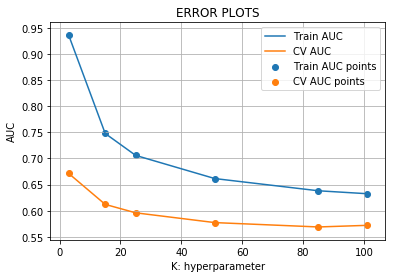

In [290]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 85,101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

From the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less.

So,from the graph the best k is found out to be 85 and now using this k we will rebuild our model and plot the roc curve to evaluate the performance on test set.

In [ ]:
best_k=85

### Evaluation

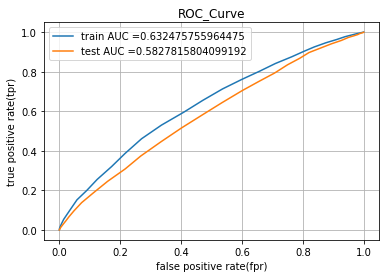

In [291]:
from sklearn.metrics import auc,roc_curve

classifier=KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
classifier.fit(X_tr,y_train)

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate(fpr)")
plt.ylabel("true positive rate(tpr)")
plt.title("ROC_Curve")
plt.grid()
plt.show()

Finding the best threshold and displaying the Confusion Matrix of train and test set for predictions using this threshold

In [292]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("\nTest confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) is  0.3522383077184881 for threshold of  0.812


Train confusion matrix
[[3064 1548]
 [8378 9455]]

Test confusion matrix
[[2029 1361]
 [6348 6762]]


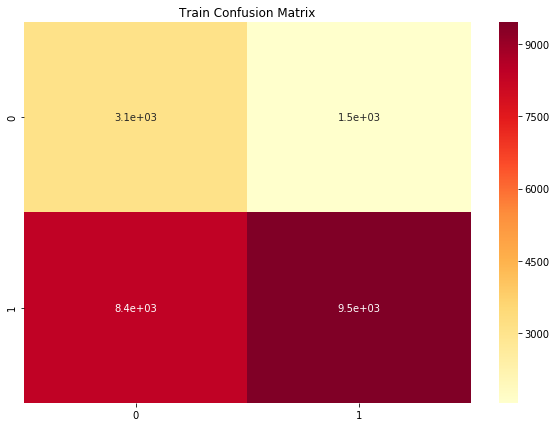

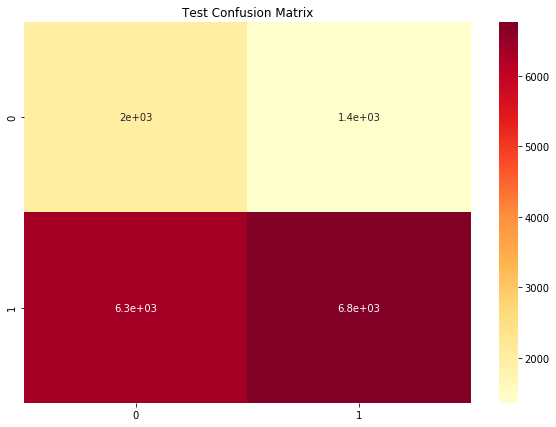

In [293]:
matrix_df = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Train Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')
matrix_df = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Test Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')

## Modelling: Applying KNN on Set3

### Concatenating all the features

In [306]:
from scipy.sparse import hstack
X_tr = hstack((avg_w2v_essay_train,avg_w2v_title_train,X_train_project_norm.reshape(-1,1),X_train_price_norm.reshape(-1,1),X_train_grade_ohe,X_train_teacher_ohe,X_train_state_ohe)).tocsr()
X_cr = hstack((avg_w2v_essay_cv,avg_w2v_title_cv,X_cv_project_norm.reshape(-1,1),X_cv_price_norm.reshape(-1,1),X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_state_ohe)).tocsr()
X_te = hstack((avg_w2v_essay_test,avg_w2v_title_test,X_test_project_norm.reshape(-1,1),X_test_price_norm.reshape(-1,1),X_test_grade_ohe,X_test_teacher_ohe,X_test_state_ohe)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(22445, 661) (22445,)
(11055, 661) (11055,)
(16500, 661) (16500,)


### Hyperparameter tuning

In [ ]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 85,101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

From the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less.

So,from the graph the best k is found out to be 85 and now using this k we will rebuild our model and plot the roc curve to evaluate the performance on test set.

In [302]:
best_k=85

### Evaluation

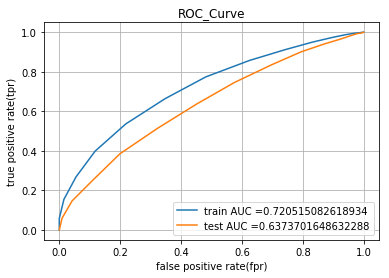

In [303]:
from sklearn.metrics import auc,roc_curve

classifier=KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
classifier.fit(X_tr,y_train)

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate(fpr)")
plt.ylabel("true positive rate(tpr)")
plt.title("ROC_Curve")
plt.grid()
plt.show()

Finding the best threshold and displaying the Confusion Matrix of train and test set for predictions using this threshold

In [308]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("\nTest confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) is  0.43317180613097844 for threshold of  0.8


Train confusion matrix
[[ 3009  1603]
 [ 5993 11840]]

Test confusion matrix
[[1857 1533]
 [4751 8359]]


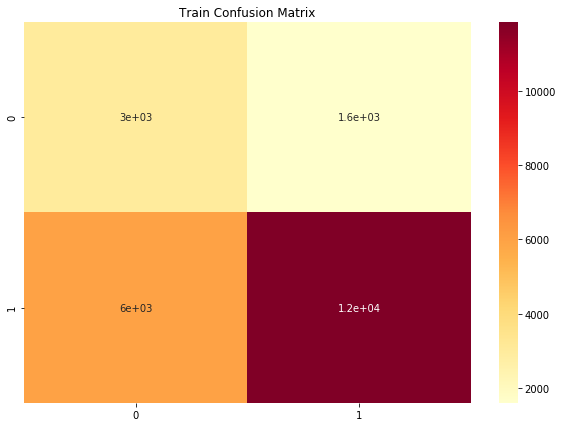

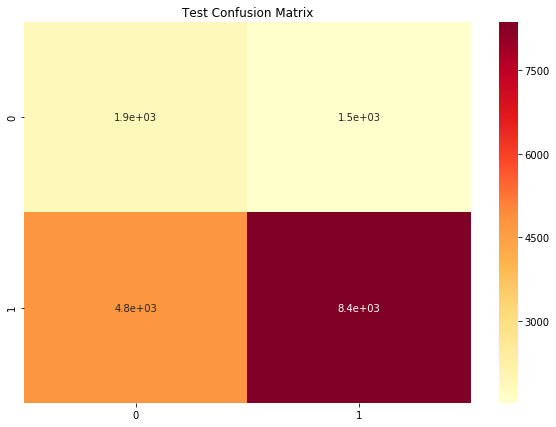

In [309]:
matrix_df = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Train Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')
matrix_df = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Test Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')

## Modelling: Applying KNN on Set4

### Concatenating all the features

In [310]:
from scipy.sparse import hstack
X_tr = hstack((tfidf_w2v_essay_train,tfidf_w2v_title_train,X_train_project_norm.reshape(-1,1),X_train_price_norm.reshape(-1,1),X_train_grade_ohe,X_train_teacher_ohe,X_train_state_ohe)).tocsr()
X_cr = hstack((tfidf_w2v_essay_cv,tfidf_w2v_title_cv,X_cv_project_norm.reshape(-1,1),X_cv_price_norm.reshape(-1,1),X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_state_ohe)).tocsr()
X_te = hstack((tfidf_w2v_essay_test,tfidf_w2v_title_test,X_test_project_norm.reshape(-1,1),X_test_price_norm.reshape(-1,1),X_test_grade_ohe,X_test_teacher_ohe,X_test_state_ohe)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(22445, 661) (22445,)
(11055, 661) (11055,)
(16500, 661) (16500,)


### Hyperparameter tuning





  0%|          | 0/6 [00:00<?, ?it/s]



 17%|█▋        | 1/6 [09:08<45:42, 548.46s/it]



 33%|███▎      | 2/6 [18:13<36:29, 547.37s/it]



 50%|█████     | 3/6 [27:14<27:16, 545.55s/it]



 67%|██████▋   | 4/6 [7:30:05<4:26:26, 7993.14s/it]



 83%|████████▎ | 5/6 [7:38:59<1:35:55, 5755.28s/it]



100%|██████████| 6/6 [7:47:56<00:00, 4189.97s/it]  

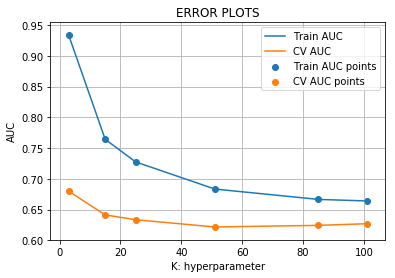

In [311]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51, 85,101]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

From the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less.

So,from the graph the best k is found out to be 101 and now using this k we will rebuild our model and plot the roc curve to evaluate the performance on test set.

In [312]:
best_k=101

### Evaluation

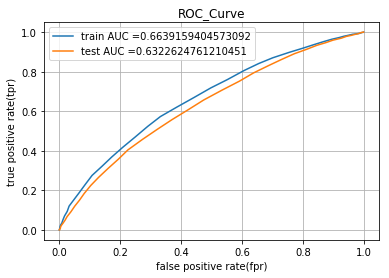

In [313]:
from sklearn.metrics import auc,roc_curve

classifier=KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
classifier.fit(X_tr,y_train)

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate(fpr)")
plt.ylabel("true positive rate(tpr)")
plt.title("ROC_Curve")
plt.grid()
plt.show()

Finding the best threshold and displaying the Confusion Matrix of train and test set for predictions using this threshold

In [314]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("\nTest confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) is  0.3829506373796905 for threshold of  0.802


Train confusion matrix
[[ 3080  1532]
 [ 7607 10226]]

Test confusion matrix
[[2135 1255]
 [5798 7312]]


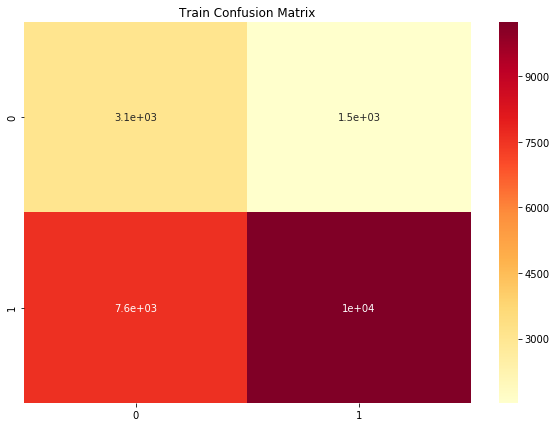

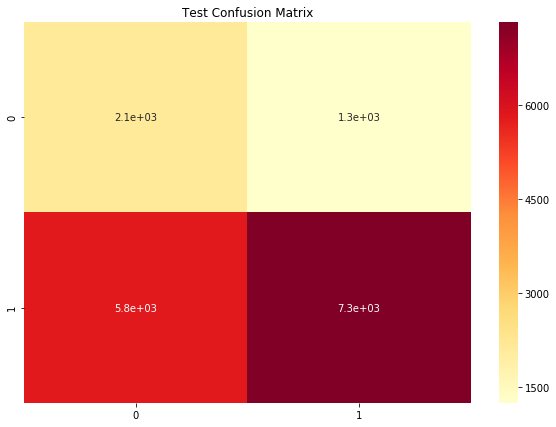

In [315]:
matrix_df = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Train Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')
matrix_df = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Test Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')

# Selecting top 2000 features from feature Set2

In [316]:
from scipy.sparse import hstack
from sklearn.feature_selection import SelectKBest, chi2
X_tr = hstack((X_train_essay_tfidf,X_train_project_title_tfidf,X_train_project_norm.reshape(-1,1),X_train_price_norm.reshape(-1,1),X_train_grade_ohe,X_train_teacher_ohe,X_train_state_ohe)).tocsr()
X_cr = hstack((X_cv_essay_tfidf,X_cv_project_title_tfidf,X_cv_project_norm.reshape(-1,1),X_cv_price_norm.reshape(-1,1),X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_state_ohe)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_project_title_tfidf,X_test_project_norm.reshape(-1,1),X_test_price_norm.reshape(-1,1),X_test_grade_ohe,X_test_teacher_ohe,X_test_state_ohe)).tocsr()

print("\n Before Performing Feature Selection")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

selector = SelectKBest(chi2, k=2000)
X_tr_new = selector.fit_transform(X_tr, y_train)
X_cr_new = selector.transform(X_cr)
X_te_new = selector.transform(X_te)

print("\n After Performing Feature Selection")
print(X_tr_new.shape, y_train.shape)
print(X_cr_new.shape, y_cv.shape)
print(X_te_new.shape, y_test.shape)


 Before Performing Feature Selection
(22445, 6808) (22445,)
(11055, 6808) (11055,)
(16500, 6808) (16500,)

 After Performing Feature Selection
(22445, 2000) (22445,)
(11055, 2000) (11055,)
(16500, 2000) (16500,)


## Modelling: Applying KNN on Selected Features

### Hyperparameter tuning





  0%|          | 0/8 [00:00<?, ?it/s]



 12%|█▎        | 1/8 [00:48<05:39, 48.55s/it]



 25%|██▌       | 2/8 [01:34<04:45, 47.62s/it]



 38%|███▊      | 3/8 [02:21<03:57, 47.55s/it]



 50%|█████     | 4/8 [03:10<03:11, 47.91s/it]



 62%|██████▎   | 5/8 [03:57<02:23, 47.72s/it]



 75%|███████▌  | 6/8 [04:48<01:37, 48.83s/it]



 88%|████████▊ | 7/8 [05:36<00:48, 48.52s/it]



100%|██████████| 8/8 [06:28<00:00, 49.39s/it]

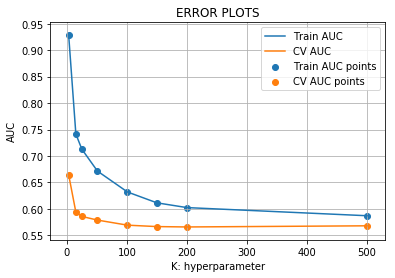

In [317]:
train_auc = []
cv_auc = []
K = [3, 15, 25, 51,101,150,200,500]
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_tr_new, y_train)

    y_train_pred = batch_predict(neigh, X_tr_new)    
    y_cv_pred = batch_predict(neigh, X_cr_new)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

From the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less.

So,from the graph the best k is found out to be 200 and now using this k we will rebuild our model and plot the roc curve to evaluate the performance on test set.

In [318]:
best_k=100

### Evaluation

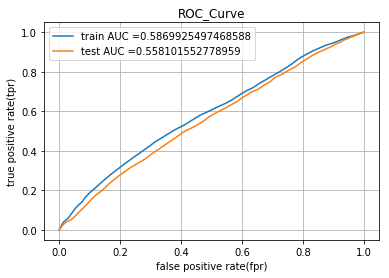

In [319]:
classifier=KNeighborsClassifier(n_neighbors=best_k,n_jobs=-1)
classifier.fit(X_tr_new,y_train)

y_train_pred = batch_predict(neigh, X_tr_new)    
y_test_pred = batch_predict(neigh, X_te_new)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate(fpr)")
plt.ylabel("true positive rate(tpr)")
plt.title("ROC_Curve")
plt.grid()
plt.show()

Finding the best threshold and displaying the Confusion Matrix of train and test set for predictions using this threshold

In [320]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("\nTest confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) is  0.3141486283384016 for threshold of  0.8


Train confusion matrix
[[2867 1745]
 [8821 9012]]

Test confusion matrix
[[2000 1390]
 [6582 6528]]


Displaying the confusion matrix as a seaborn heatmap

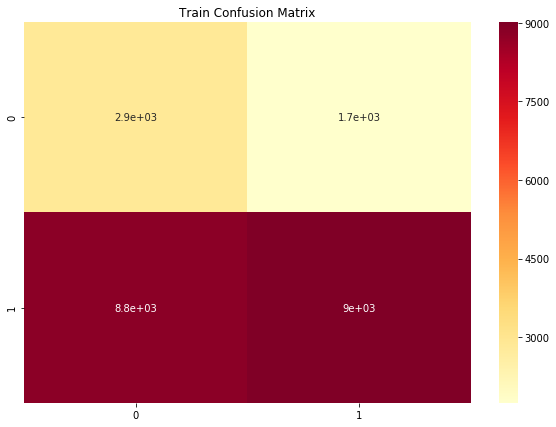

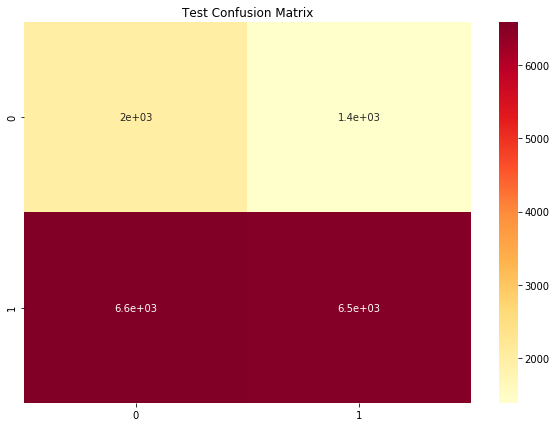

In [321]:
matrix_df = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Train Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')
matrix_df = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), index = [0,1],columns = [0,1])
plt.figure(figsize = (10,7))
plt.title('Test Confusion Matrix')
sns.heatmap(matrix_df, annot=True,cmap='YlOrRd')

# Summary

In [322]:
from prettytable import PrettyTable
    
table = PrettyTable()

table.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]
table.add_row(["BOW", "Brute KNN", "101", "0.666"])
table.add_row(["TFIDF", "Brute KNN", "85", "0.587"])
table.add_row(["W2V", "Brute KNN", "85", "0.632"])
table.add_row(["TFIDFW2V", "Brute KNN", "101", "0.639"])
table.add_row(["TFIDF(Top 2000 features)", "Brute KNN", "100", "0.55"])

print(table)

+--------------------------+-----------+-----------------+-------+
|        Vectorizer        |   Model   | Hyper parameter |  AUC  |
+--------------------------+-----------+-----------------+-------+
|           BOW            | Brute KNN |       101       | 0.666 |
|          TFIDF           | Brute KNN |        85       | 0.587 |
|           W2V            | Brute KNN |        85       | 0.632 |
|         TFIDFW2V         | Brute KNN |       101       | 0.639 |
| TFIDF(Top 2000 features) | Brute KNN |       100       |  0.55 |
+--------------------------+-----------+-----------------+-------+
